In [480]:
import pandas as pd
import geopandas as gpd
 
def ee_array_to_df(arr, band):
    """
    We create a function with an array as input
    We return a pandas df
    """
    df = pd.DataFrame(arr)
     
    # we rearrange the header
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns = headers)
 
    # we remove raws without data inside:
    df = df[['longitude', 'latitude', 'time', band]].dropna()
     
    # We converr the data to numeric values
    df[band] = pd.to_numeric(df[band], errors='coerce')
     
    # We also convert the Time filed into a datetime
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')
     
    # We keep the columns we want
    # df = df[['time','datetime', band]]
     
    return df


def geojson2gee(geojson_path):
    """
    Use geopandas and google earth engine api to convert geojson to gee featurecollection 
    """
    
    shapefile = gpd.read_file(geojson_path)
    
    features = []
    for i in range(shapefile.shape[0]):
        geom = shapefile.iloc[i:i+1,:] 
        jsonDict = eval(geom.to_json()) 
        geojsonDict = jsonDict['features'][0] 
        features.append(ee.Feature(geojsonDict)) 

    gee_featurecollection = ee.FeatureCollection(features)
    
    return gee_featurecollection

In [481]:
# Import the Earth Engine Python Package
import ee # !pip install earthengine-api

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

import geopandas as gpd

ee.Initialize()

In [484]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
from shapely.ops import unary_union
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../data/hand_annotations/gee_training_data/*.geojson'
shape_files = glob.glob(shape_file_path)
geojson_path = shape_files[0]

shape_files[0:3], cwd, path

(['../../data/hand_annotations/gee_training_data/urban_trainingdata_export.geojson',
  '../../data/hand_annotations/gee_training_data/vegetation_trainingdata_export.geojson',
  '../../data/hand_annotations/gee_training_data/water_trainingdata_export.geojson'],
 '/home/ubuntu/rimbun.io/03_Add_metadata/02_green_area_change',
 '../../data/nir_green_blue/vectors/Jakarta_202_pansharpen_True_2019-07-23_03:16_1030010096702700_05-18-2020_08:55:26.geojson')

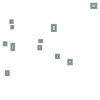

In [485]:
shapefile = gpd.read_file(geojson_path)

if len(shapefile) > 1:

    shapes_check = MultiPolygon([geom for geom in shapefile.geometry])
    
else:
    
    shapes_check = shapefile.geometry[0]
    
shapes_check

In [486]:
rect = geojson2gee(geojson_path)



In [487]:
## Example geometry structure
# feature_geometry = {
#     'type': 'MultiPolygon',
#     'coordinates': [[[
#         [-120, 35],
#         [-120.001, 35],
#         [-120.001, 35.001],
#         [-120, 35.001],
#         [-120, 35]
#     ]]]
# }

In [488]:
# convert geometry to JSON format
rect_JSON = rect.getInfo()#['coordinates']

rect_JSON

{'type': 'FeatureCollection',
 'columns': {'id': 'String', 'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[106.8039899792268, -6.159664733014874],
      [106.80643615384838, -6.159664733014874],
      [106.80643615384838, -6.15386191000851],
      [106.8039899792268, -6.15386191000851],
      [106.8039899792268, -6.159664733014874]]]},
   'id': '0',
   'properties': {'id': '0'}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[106.79695186277172, -6.155355289634073],
      [106.79944095273754, -6.155355289634073],
      [106.79944095273754, -6.152496530678216],
      [106.79695186277172, -6.152496530678216],
      [106.79695186277172, -6.155355289634073]]]},
   'id': '1',
   'properties': {'id': '1'}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[106.82922420163891, -6.152368526186156],
      [106.83197078367016, -6.152368526186156],
      [106.83197078

In [489]:
# set variables
SCALE = 10;
polarization = 'VV'; # Polygonvertical/vertical or vertical/horizontal

In [490]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2019-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect)\


In [491]:
# visualize resulting image
img_url = S1.first().getThumbUrl({
    'region':rect.geometry(),
    'min':-25,
    'max':0,
    'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff'],
    'maxPixels': 1e9
})

Image(url = img_url)

In [492]:
isinstance(rect, ee.ComputedObject)

True

In [493]:
scale_list = [10, 20, 100, 200, 300]

for scale_factor in scale_list:

    try: 
        gee_data_array = S1.getRegion(rect, scale = scale_factor).getInfo()
        print('succes at scale ' + str(scale_factor))
        break
    except:
        print('error at scale ' + str(scale_factor))
        continue
        

succes at scale 10


In [494]:
df = ee_array_to_df(gee_data_array, 'VV')

In [495]:
df.describe()

,VV
count,334896.000000
mean,-3.952757
std,3.236582
min,-16.696298
25%,-6.139662
50%,-4.247836
75%,-2.139019
max,13.809344


In [496]:
import geopandas as gpd

In [497]:
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude))

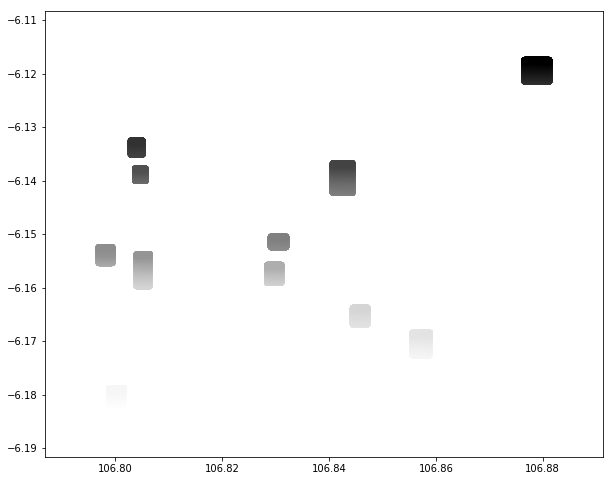

In [498]:
gdf.plot(figsize = (10,10), cmap='Greys')

In [471]:
gdf.VV[0:5]

0   -11.716133
1    -7.660871
2    -7.470847
3    -9.131988
4   -11.700050
Name: VV, dtype: float64

(106.84368872900488,
 106.8505154977845,
 -6.146319595600737,
 -6.1391300615462505)

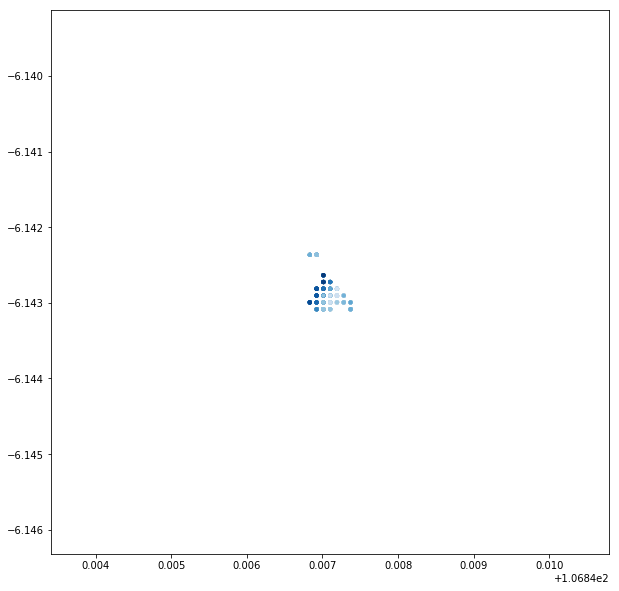

In [472]:
fig = plt.figure(figsize = (10,10))

plt.scatter(df.longitude, df.latitude, c=df.VV, cmap='Blues', s = 10)
plt.axis('equal')

In [473]:
img_url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/257973e8c59dc1608c88bf18ec86a993-40f00ebb63d013b5022ee4dfefe730bf:getPixels'

(9, 9, 4)


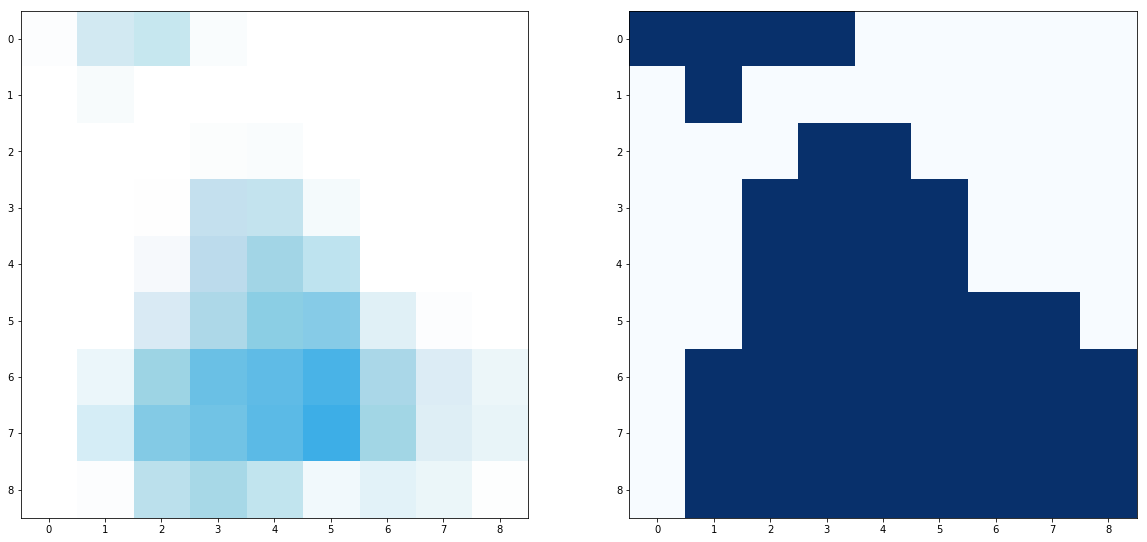

In [475]:
import imageio

# download image as np array
im = imageio.imread(img_url)

# apply value mask
array_mask = np.array(im == 0).astype(int)

print(array_mask.shape)

# plot results
plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(im, cmap = 'jet')
plt.subplot(122)
plt.imshow(-array_mask[:,:,0], cmap = 'Blues')